# In Depth: Naive Bayes Classification

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often __suitable for very high-dimensional datasets.__

Because they are so fast and have so few tunable parameters, they end up being very useful __as a quick-and-dirty baseline for a classification problem.__



## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.


In Bayesian classification, we're interested in __finding the probability of a label given some observed features__, which we can write as $$P(L~|~{\rm features})$$.


Bayes's theorem:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$



$$ \text{ All we need now is some model by which we can compute    } P({\rm features}~|~L_i) \text{ for each label.}$$

__Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.__


__Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.__



__the "naive" in "naive Bayes"__: 

if we make very naive assumptions about the generative model for each label (__independent of each other__), we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.


In [92]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes

The easiest naive Bayes classifier to understand is Gaussian naive Bayes.


In this classifier, the assumption is that **data from each label is drawn from a simple Gaussian distribution**.


Imagine that you have the following data:

[(-15, 5), (-8, 8)]

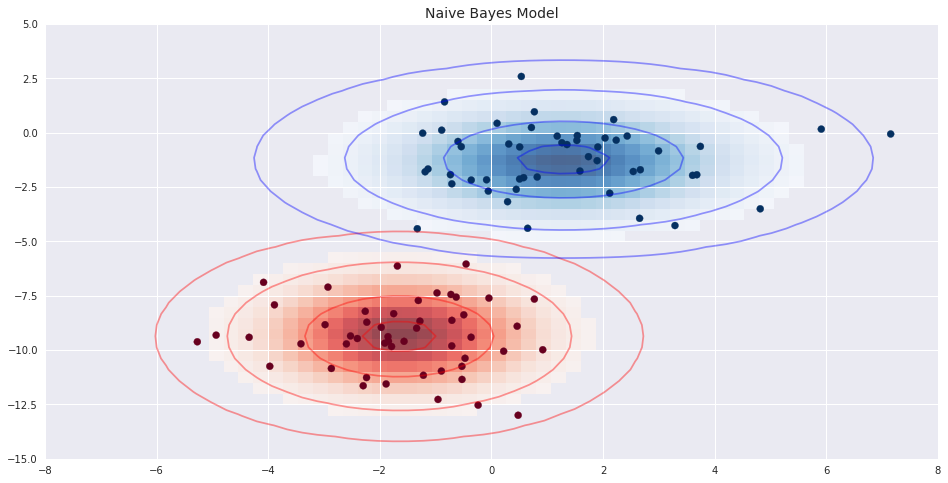

In [93]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)

fig, ax = plt.subplots(figsize=(16,8))

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1) ## gaussian distribution
    Pm = np.ma.masked_array(P, P < 0.05)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.7,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.4)
    
ax.set(xlim=xlim, ylim=ylim)

One extremely fast way to create a simple model is to __assume that the data is described by a Gaussian distribution with no covariance between dimensions.__

This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all needed to define such a distribution.


__The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses.__

With this generative model in place for each class, we can now compute the likelihood $$P({\rm features}~|~L_1)$$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

use ``sklearn.naive_bayes.GaussianNB`` :

In [94]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [95]:
Xnew = [-6, -14] + [14, 18] * np.random.RandomState(2018).rand(2000, 2)
ynew = model.predict(Xnew)

In [96]:
# a little notes: what does np.c_ do?
np.c_[np.array([1,2,3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

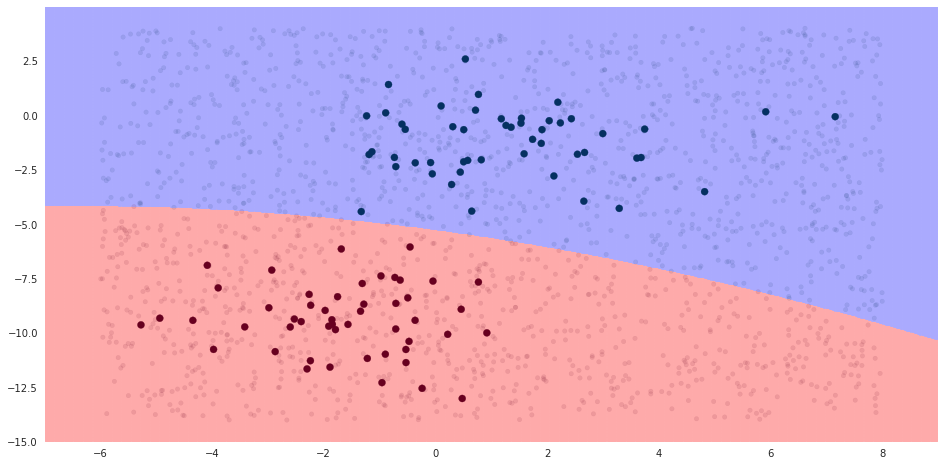

In [97]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(16,8))

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

#1. boundary
x_min, x_max = Xnew[:, 0].min() - 1, Xnew[:, 0].max() + 1
y_min, y_max = Xnew[:, 1].min() - 1, Xnew[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.7)

# highlighted points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

lim = plt.axis()

# new added points
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1) # the background points

plt.axis(lim);

We see a slightly curved boundary in the classifications—__in general, the boundary in Gaussian naive Bayes is quadratic__.


In [98]:
yprob = model.predict_proba(Xnew)
yprob.round(2)

array([[ 1.  ,  0.  ],
       [ 0.33,  0.67],
       [ 0.  ,  1.  ],
       ..., 
       [ 0.  ,  1.  ],
       [ 0.  ,  1.  ],
       [ 0.  ,  1.  ]])

__The columns give the posterior probabilities of the first and second label, respectively.__

If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.


## Multinomial Naive Bayes

Another useful example is multinomial naive Bayes, where the features are assumed to be __generated from a simple multinomial distribution.__


__The multinomial distribution describes the probability of observing counts among a number of categories__, and thus multinomial naive Bayes is __most appropriate for features that represent counts or count rates__.


The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we __model the data distribuiton with a best-fit multinomial distribution__.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.

eg:

use the sparse word count features from the `20 Newsgroups corpus(in sklearn datasets)` to show how we might classify these short documents into categories.


In [99]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [145]:
categories=[data.target_names[i] for i in np.random.randint(0, len(data.target_names), 4, dtype=int)]
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [146]:
categories

['comp.sys.mac.hardware', 'comp.graphics', 'sci.crypt', 'talk.politics.guns']

In [147]:
print(train.data[5])

From: bressler@iftccu.ca.boeing.com (Rick Bressler)
Subject: Re: "Proper gun control?" What is proper gun control? (was Re: My Gun is like my American Express Card)
Organization: Boeing Commercial Airplane Group
Lines: 16

/ iftccu:talk.politics.guns / hays@ssd.intel.com (Kirk Hays) /  3:31 pm  Apr 13, 1993 /

>Some of the pro-gun posters in this group own no guns.  The dread 
>"Terminator", aka "The Rifleman", owned no firearms for several years 
>while posting in this group, as an example.  There are others.

Good point, Kirk.

He's still around too.  He's responded by email to a couple of my posts, 
and gosh darn, he's gotten down right civil!  This happed about the time 
he got his first firearm.  Wonder if there is a relationship here?  Turns
out that MOST people (at least the ones who are not criminals to start
with) act responsibility once given the chance.

Rick.




For this we will use the __TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier__:

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [151]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

we can evaluate them to learn about the performance of the estimator.


confusion matrix:

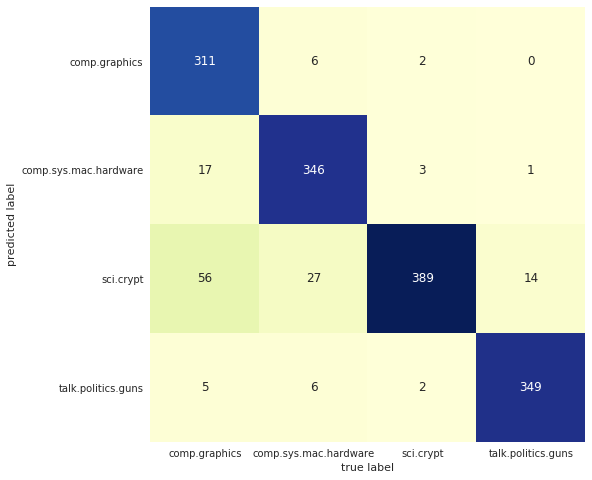

In [153]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.set(rc={'figure.figsize':(16,8)})
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names, cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [154]:
def predict_category(test_string, train=train, model=model):
    pred = model.predict([test_string])
    return train.target_names[pred[0]]

In [157]:
predict_category('opengl game design')

'comp.graphics'

In [167]:
predict_category('hackintosh') # wrong one

'sci.crypt'

In [168]:
predict_category('president weapon control')

'talk.politics.guns'

## Naive Bayes Pros and Cons

Because naive Bayesian classifiers make 'naive' assumptions about data, they will generally not perform as well as a more complicated model, it is often a good choice __as an initial baseline classification__.

Only suitable for the following occasions:

- When the naive assumptions actually match the data (__actually independent__)
- For __very well-separated categories__, when model complexity is less important
- For __very high-dimensional__ data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together. This means that __clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions__, assuming the new dimensions actually add information.


__For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: if data is large enough, even a simple model can be very powerful.__